# K-means Clustering
---



**Author:** Shreya Chawla
    
**Date:** 9th Dec 2020

**Course:** [COMP6670](https://wattlecourses.anu.edu.au/course/view.php?id=31701) Introduction to Machine Learning, Australian National University

**Course By:** [Dr. Liang Zheng](https://cecs.anu.edu.au/people/liang-zheng)

**My Explanation:** Can be found [here](https://github.com/shreya888/Machine-Learning-in-Python/blob/main/K-means-Clustering.md).

**Websites referred to:**
1. https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
2. https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
3. https://stackoverflow.com/questions/25823608/find-matching-rows-in-2-dimensional-numpy-array
4. https://medium.com/analytics-vidhya/comparison-of-initialization-strategies-for-k-means-d5ddd8b0350e
5. https://stackoverflow.com/questions/9775297/append-a-numpy-array-to-a-numpy-array
6. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
7. https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca

## Task 0: Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.core.display import HTML

## Task 1: Clustering
-----------
The above online resources will help if unsure how to start. Else we are good to go.
This code interprets how k-means is a specific case of a more general Expectation Maximisation algorithm. This is explained toward the end of [this](https://stanford.edu/~cpiech/cs221/handouts/kmeans.html) article.

First, lets loading the dataset.

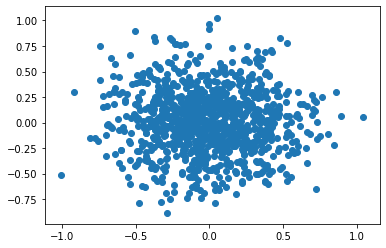

In [2]:
X = np.load("./data.npy")
plt.scatter(X[:,0], X[:,1])
plt.show()

The dataset contains 1000 4-dimensional samples. However, we don't know how many centroids it contains. The number of centroids is more than 5 but less than 10. We need to figure it out in the clustering procedure.

-----

K-means is a special, simple case of the Expectation Maximisation (EM) algorithm.

This simplified EM (k-means), is divided into two steps.

The **E-Step**, where for every sample in your dataset you find which "centroid" that datapoint is closest to that sample, and record that information.

The **M-Step**, where you move each "centroid" to the center of the samples which were found to be closest to it in the **E-Step**.

Each *centroid* is simply an estimated mean of a cluster. If you have $1$ centroid, then this centroid will become the mean of all your data.

If each of your samples, such as the 400 you generated in the previous question, are of dimension $n$, then each of your centroids will be of dimension $n$.

Centroids are initially random values, and the k-means algorithm attempts to modify them so that each one represents the center of a cluster.

---

**TASK 2.1:** Write a function $initialise\_parameters(m, n, X) = C$ which generates $m$ centroids, each of dimension $n$, and stores them in a matrix $C \in \mathbb{R}^{m \times n}$.

No two centroids should be the same, and **must not** be hard coded. Generate these parameters using a sensible initialisation method such as those described in the first link below. You will be judged based on whether the method you choose is sensible and likely to result in kmeans converging to good result.

---

**HINT:** 
- https://en.wikipedia.org/wiki/K-means_clustering#Initialization_methods
- https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html

In [3]:
# Implementing k means++ algorithm
import sys
def initialise_parameters(m, n, X):
    C = []
    # Choose the 1st centroid randomly from the datapoints in X
    C.append(X[np.random.randint(X.shape[0])])
    # For the next m-1 centroids, we need to choose them as far from the 1st as possible
    for c_id in range(m-1):
        dist = []
        for i in range(X.shape[0]):
            point = X[i, :]
            # For every point in X, choose the min distance between
            # sys.maxsize and euclidean distance of points from the centroids
            d = sys.maxsize
            for j in range(len(C)):
                temp_dist = np.linalg.norm(point - C[j])
                d = min(d, temp_dist)
            dist.append(d)
              
        # Select data point with maximum distance from the 1st centroid as our next centroid
        dist = np.array(dist)
        next_centroid = X[np.argmax(dist)]
        C.append(next_centroid)
        dist = []  
    return np.array(C)

C = initialise_parameters(2, 4, X)
print(C)

[[ 0.37750806  0.4773931   1.4734237   1.60591464]
 [ 0.25613997  0.22100056 -2.0508867  -2.44353477]]


Now we implement k-means.

---
   **TASK 2.2:** Create a function $E\_step(C, X) = L$, where $L$ is a matrix of the same dimension of the dataset $X$.
   
   This function is is the **E-Step** (or "assignment step") mentioned earlier.

---

**HINT:** 
- https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
- https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm
- Each row of $L$ is a centroid taken from $C$.

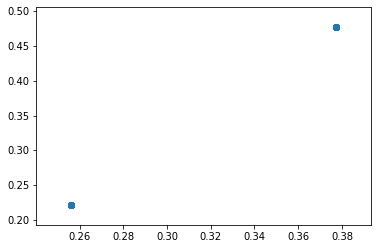

In [4]:
def E_step(C, X):
    L = np.zeros(X.shape)
    for i in range(X.shape[0]):
        dist = {}
        # Finding distance from each centroid to each datapoint
        for j in range(C.shape[0]):
            dist.update({j: np.linalg.norm(X[i]-C[j])})
        # Assign points with minimum distance from the centroids to one of the k clusters
        idx = [key for key in dist if dist[key] == min(dist.values())]
        L[i] = C[idx]
    return L

L = E_step(C, X)
plt.scatter(L[:, 0], L[:, 1])
plt.show()

---

**TASK 2.3:** Create a function $M\_step(C, X, L) = C$ which returns $C$ modified so that each centroid in $C$ is placed in the middle of the samples assigned to it. This is the **M-Step**.

In other words, make each centroid in $C$ the average of all the samples which were found to be closest to it during the **E-step**. This is also called the "update step" for K-means.

---

**HINT:** https://docs.scipy.org/doc/numpy/reference/generated/numpy.array_equal.html

In [5]:
def M_step(C, X, L):
    # Updated centroid is the central point of each cluster
    new_cluster = np.zeros(C.shape)
    # Based on the distance, a new centroid is assigned to each cluster
    for i in range(C.shape[0]):
        cluster = np.where((L == C[i]).all(axis=1))[0]
        if cluster.shape[0] > 0:
            new_cluster[i] = sum(X[cluster])/cluster.shape[0]
        else:
            new_cluster[i] = C[i]
    return new_cluster
M_step(C,X,L)

array([[-1.88726939e-02,  1.38785228e-02,  3.64994137e-01,
         4.52829864e-01],
       [ 1.13922636e-02,  1.13908033e-03, -1.02770169e+00,
        -1.26930082e+00]])

In [6]:
C2 = np.array([[0,0],[1,0]])
X2 = np.array([[0.1, 0.1], [0, 0.1], [0.1, 0], [0, 0]])
L2 = np.array([[0, 0], [0, 0], [0, 0], [0, 0]])
assert not np.any(np.isnan(M_step(C2, X2, L2))), "Some centroids are nan"
HTML('<div class="alert alert-block alert-success">Centroids are valid!</div>')

---
**TASK 2.4:** Implement $kmeans(X, m, i) = C, L$ which takes a dataset $X$ (of any dimension) and a scalar value $m$, and uses the previous 3 functions you wrote to:
- generate $m$ centroids.
- iterate between the E and M steps $i$ times (ie, it iterates $i$ times) to classify the $m$ clusters.

...and then returns:
- $C$, the centers of the $m$ clusters after $i$ iterations.
- $L$, the labels (centroid values) assigned to each sample in the dataset after $i$ iterations.
---

In [7]:
def kmeans(X, m, i):
    
    L = np.zeros(X.shape)
    C = initialise_parameters(m, X.shape[1], X)
    # Iterate over EM steps to find a locally optimal solution
    while(i):
        L = E_step(C, X)
        C = M_step(C, X, L)
        i -= 1
    
    return C, L

---
**Task 2.5:** The following code is to display the result. However, due to the limitation of our visualization tools, it can only presents the data in the two dimensional space. While the dimension of the dataset is 4, we really want to visualize the data in the two dimensional figure. Besides, the number of centroids is not determined yet.

This task is ask you to modify the following code so as to give the best visualization effect. 

---
**HINT:** You only need to change "number of centroid", "dimension1", "dimension2" to a number, which are quoted by "#" in the following code. 

Initial Parameters:
[[ 0.37750806  0.4773931   1.4734237   1.60591464]
 [ 0.25613997  0.22100056 -2.0508867  -2.44353477]]

Final Parameters:
[[-3.12595827e-02  7.66544119e-03  7.32444784e-01  7.23499116e-01]
 [ 1.80182894e-02 -2.84548382e-02 -1.73314207e+00 -1.74422749e+00]
 [-2.30938038e-02  1.71549863e-02  1.76052530e+00 -1.73716493e+00]
 [-1.08975530e-02  1.26213183e-02 -2.01514271e+00  1.74712290e+00]
 [-2.68311120e-03  1.72757846e-02  1.49565927e+00  1.75278340e+00]
 [-1.15362482e-03  3.56500354e-02 -5.02332315e-01 -7.41382419e-01]
 [-1.61647729e-02  2.54639072e-02  1.00871817e+00 -7.26380789e-01]
 [-2.05541611e-02 -2.94840798e-03 -7.34726213e-01  7.52580271e-01]]


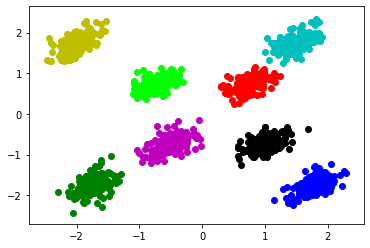

In [8]:
# With seed equal to 1, kmeans algorithm returns all seperated clusters,
# else due to bad (random) initialization, the clusters are are messy
np.random.seed(1)
m = 8 #number of centroid
i = 100 #number of iterations

#CODE TO DISPLAY RESULTS
C_final, L_final = kmeans(X, m, i)
print('Initial Parameters:')
print(C)
print('\nFinal Parameters:')
print(C_final)

def allocator(X, L, c):
    cluster = []
    for i in range(L.shape[0]):
        if np.array_equal(L[i, :], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'lime', 'wheat', 'fuchsia', 'pink']
for i in range(m):
    cluster = allocator(X, L_final, C_final[i, :])
    plt.scatter(cluster[:, 2],#dimension1#], 
                cluster[:, 3],#dimension2#], 
                c=colours[i])
plt.show()

---
**TASK 2.6:** Use your own words to explain how you found the number of centroids in Task 2.5 and how you might do this in the real world.

---

Answer: 
1. Upon plotting the data X with the plot's x-axis as 2nd dimension and y-axis as 3rd dimension of X, it is clear that there are 8 different non-overlapping clusters. Since the data is 4 dimensional and is displayed in 2 dimensions only, hence some overlapping is viewed.
2. In the real world, the elbow algorithm is used. The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. By default, the distortion score is computed, the sum of square distances from each point to its assigned center. The greatest k before the kink of the graph would be the ideal number of clusters.
(The definition of the elbow method is from [sklearn documentation](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#:~:text=The%20elbow%20method%20runs%20k,point%20to%20its%20assigned%20center).